**Gradient Boosting** is a method where you build several small decision trees, one after another, and each tree tries to fix the mistakes of the previous ones. This process helps improve the overall prediction accuracy.

### Simple Example of Gradient Boosting:

Let's say you are trying to predict the price of a house based on its features like square footage, number of bedrooms, etc. You start by making a simple prediction (like guessing the average price of all houses). Then, you improve the prediction step by step using decision trees.

#### Step-by-Step Breakdown:

1. **Start with a simple model (guess the average):**

   You know the average house price is $300,000. So, your first prediction for every house is $300,000.

   - Actual prices: [350,000, 200,000, 400,000, 250,000]
   - Predictions: [300,000, 300,000, 300,000, 300,000]
   - Errors (Actual - Predicted): [50,000, -100,000, 100,000, -50,000]

2. **Build the first tree to fix the errors:**

   The tree looks at the errors from the previous step. It tries to find patterns in the features (e.g., square footage, number of bedrooms) that can help reduce the errors.

   After training the tree, it might decide that for houses with 3 bedrooms, we should predict $350,000, and for houses with 2 bedrooms, we should predict $270,000. This new tree aims to fix the errors made by the initial simple model.

   - New predictions after the first tree: [350,000, 270,000, 400,000, 270,000]
   - Errors: [0, -30,000, 0, -30,000]

3. **Update the model's predictions:**

   Now, you update your model’s predictions. Instead of just using the original guess of $300,000, you adjust based on the first tree's output.

   - Updated predictions: [325,000, 285,000, 400,000, 285,000] (adding the correction from the first tree to the previous guesses).
   - Errors: [25,000, -15,000, 0, -15,000]

4. **Build the second tree to fix the new errors:**

   Now, the second tree focuses on fixing the new errors (the difference between the updated predictions and the actual prices). This tree might decide that houses with 2 bathrooms should be adjusted by another $10,000.

   - New predictions after the second tree: [325,000, 295,000, 400,000, 295,000]
   - Errors: [25,000, -5,000, 0, -5,000]

5. **Repeat the process:**

   You keep adding new trees, each one focusing on reducing the errors from the previous step. After enough trees, your predictions become very close to the actual prices.

   - Final predictions might be: [350,000, 300,000, 400,000, 300,000]
   - Errors: [0, 0, 0, 0]

6. **Stop when the model is good enough:**

   The process repeats until the errors are small enough, or you reach a pre-defined number of trees. The model becomes more accurate after each step, and you have a final prediction that is much better than the initial guess of $300,000.


In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import xgboost as xgb


In [3]:

# 2. Load Main Dataset
df = pd.read_csv('application_train.csv')
print("Data shape:", df.shape)
df.head()


Data shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:

# 3. Basic Preprocessing
# Drop columns with >40% missing values
null_thresh = 0.4
df = df[df.columns[df.isnull().mean() < null_thresh]]

# Fill numeric columns with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [5]:

# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))



The code encodes categorical variables (i.e., columns with text or non-numeric data) into numbers. It does this by applying a technique called Label Encoding, where each unique category in the column gets assigned a unique number. For example, if a column contains "Male" and "Female," "Male" might be encoded as 0 and "Female" as 1.

In [6]:
# 4. Feature/Target Split
X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df['TARGET']

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


The random_state=42 in the code is used to set a seed for the random number generator. This ensures that any random processes (like splitting data into training and testing sets, or random initialization in algorithms) will be the same every time you run the code. In other words, it makes your results reproducible. The number "42" is just a commonly used arbitrary value, but any fixed integer can be used as a seed.

Stratify helps to maintain the same ratio of different classes in both the training and test sets, which is especially important for imbalanced datasets.

For example, if your original dataset has 80% of class 0 and 20% of class 1, using stratify=y will ensure that:
The training set has approximately 80% class 0 and 20% class 1.
The test set will have the same class distribution as the original data, 80% class 0 and 20% class 1.



In [7]:

# 6. LightGBM Model
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict_proba(X_test)[:, 1]



[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3157
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


**LightGBM (Light Gradient Boosting Machine)** is an efficient machine learning algorithm that is based on gradient boosting. It is optimized to handle large datasets with high performance.

**Parameters:**
- `n_estimators=100`: Specifies the number of trees (models) that LightGBM will create. Each tree corrects the errors of the previous one, making the model more accurate.
- `random_state=42`: This ensures that the model results are reproducible. Using the same seed (42 in this case) will ensure that the training process gives the same results each time.
- `class_weight='balanced'`: Used to handle imbalanced datasets by adjusting the weight of each class. In case there are fewer positive samples, this parameter helps the model give more importance to the minority class, improving its prediction accuracy for that class.



**Predictions (`predict_proba(X_test)[:, 1]`):**
- After training, the model predicts probabilities for the positive class (class 1) in the test set (`X_test`). The `[:, 1]` part selects the probability for the positive class.


In [8]:
# 7. XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]


/Users/yakrishn/Documents/yashwant/Kaggle/Kaggle/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:57:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### XGBoost (Extreme Gradient Boosting)

XGBoost is a popular and powerful machine learning algorithm that implements a gradient boosting framework. It's used for supervised learning tasks like classification and regression. XGBoost is known for its high performance and efficiency, especially on large datasets.

XGBoost builds an ensemble of decision trees, where each tree is built sequentially, with each new tree correcting the errors made by the previous trees. The algorithm uses the gradient descent approach to minimize the loss function.





Parameters:

n_estimators=100:

This specifies the number of boosting rounds (or trees) to be built. In this case, XGBoost will build 100 decision trees.

random_state=42:

This sets the random seed for reproducibility. By setting random_state=42, the results will be the same every time you run the code (if other conditions remain constant).

scale_pos_weight=10:

This is used for dealing with imbalanced datasets. It adjusts the weight of positive class examples in the loss function. A value greater than 1 means that the positive class is weighted more heavily, and this helps to correct the imbalance in the data. In this case, the positive class is weighted 10 times more than the negative class.

use_label_encoder=False:

This parameter controls whether or not to use the label encoder for encoding target labels. XGBoost deprecated the use of label encoding in recent versions, so setting use_label_encoder=False avoids warnings related to label encoding. If you leave it as True, you may see a warning indicating that it’s not used.

eval_metric='logloss':

This specifies the evaluation metric to be used during training. In this case, logloss (logarithmic loss) is used as the evaluation metric. Log loss is commonly used for binary classification problems, where the goal is to minimize the difference between predicted probabilities and actual labels.


Model Prediction:
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]:

This code generates the predicted probabilities for the positive class (class 1) for each sample in the test set X_test.

The predict_proba() method returns a 2D array of probabilities, where each row contains the probabilities of both classes (0 and 1). By using [:, 1], we are selecting only the probabilities for class 1.

In [9]:

# 8. Combine Predictions (Averaging)
final_preds = (lgb_preds + xgb_preds) / 2
final_binary = (final_preds >= 0.5).astype(int)

# 9. Evaluation
print("ROC AUC:", roc_auc_score(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_binary))
print("Classification Report:\n", classification_report(y_test, final_binary))



ROC AUC: 0.7554063559351771
Confusion Matrix:
 [[42252 14286]
 [ 1864  3101]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.75      0.84     56538
           1       0.18      0.62      0.28      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.89      0.74      0.79     61503



### Model Evaluation Metrics

- **ROC AUC**: 0.7554
  - The ROC AUC score of 0.7554 indicates the model has a good ability to distinguish between the two classes.

- **Confusion Matrix**:
[[42252 14286]
[ 1864 3101]]

markdown
Copy
Edit
- The matrix shows the number of true positives, false positives, true negatives, and false negatives:
  - 42,252 true negatives
  - 14,286 false positives
  - 1,864 false negatives
  - 3,101 true positives

- **Classification Report**:
- **Class 0** (negative class):
  - Precision: 0.96 (96% of predicted negatives are correct)
  - Recall: 0.75 (75% of actual negatives are identified correctly)
  - F1-Score: 0.84 (harmonic mean of precision and recall)
- **Class 1** (positive class):
  - Precision: 0.18 (18% of predicted positives are correct)
  - Recall: 0.62 (62% of actual positives are identified correctly)
  - F1-Score: 0.28 (harmonic mean of precision and recall)

- **Accuracy**: 0.74
- The model correctly predicts 74% of the total instances.

- **Macro Average**:
- Average of the precision, recall, and F1-score across both classes (without considering class imbalance).
- **Macro avg**: Precision: 0.57, Recall: 0.69, F1-Score: 0.56

- **Weighted Average**:
- Average metrics weighted by the number of instances in each class.
- **Weighted avg**: Precision: 0.89, Recall: 0.74, F1-Score: 0.79

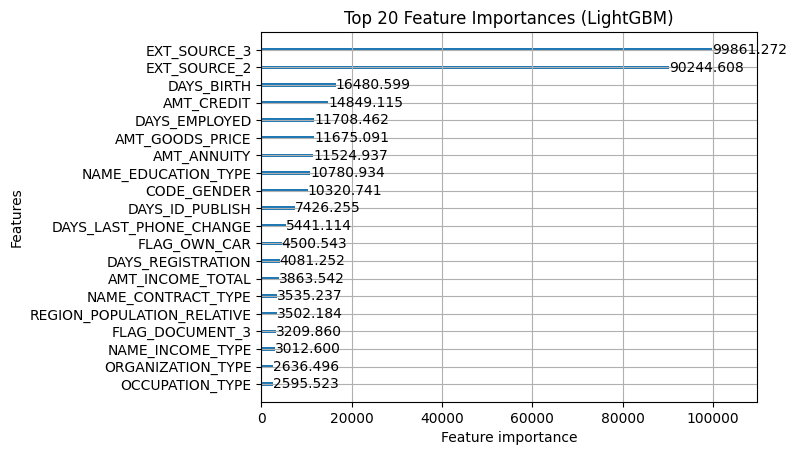

In [10]:
# 10. Feature Importance from LightGBM
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (LightGBM)")
plt.show()
